# HiFi-GAN Quality Analysis

Этот ноутбук проводит анализ качества вокодера HiFi-GAN согласно требованиям ДЗ:

1. **Анализ на обучающих данных (RUSLAN)**
2. **Анализ на внешних данных**
3. **Full TTS System Analysis** (опционально)

**Аудио файлы сохраняются в папку `analysis_output/`** — их можно послушать в любом плеере.

## Setup

In [9]:
import os
import sys
from pathlib import Path

# Setup paths
PROJECT_ROOT = Path('.').absolute()
sys.path.insert(0, str(PROJECT_ROOT))

import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model import Generator
from src.transforms import MelSpectrogram, MelSpectrogramConfig

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Create output directory for audio files
OUTPUT_DIR = PROJECT_ROOT / 'analysis_output'
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"\nAudio files will be saved to: {OUTPUT_DIR}")
print("You can listen to them in any audio player!")

Device: cpu

Audio files will be saved to: /home/krugden/Desktop/dla_hw3/HW3_TTS/analysis_output
You can listen to them in any audio player!


In [3]:
# Load model
WEIGHTS_PATH = PROJECT_ROOT / 'models_weights' / 'generator_best.pt'

# Mel config (same as training)
mel_config = MelSpectrogramConfig(
    sr=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
    f_min=0.0,
    f_max=8000.0,
)
mel_transform = MelSpectrogram(mel_config).to(device)

# Load generator
generator = Generator(
    in_channels=80,
    hidden_channels=512,
    upsample_rates=(8, 8, 2, 2),
    upsample_kernel_sizes=(16, 16, 4, 4),
    resblock_kernel_sizes=(3, 7, 11),
    resblock_dilations=((1, 3, 5), (1, 3, 5), (1, 3, 5)),
)

checkpoint = torch.load(WEIGHTS_PATH, map_location=device, weights_only=False)
if isinstance(checkpoint, dict) and 'generator' in checkpoint:
    generator.load_state_dict(checkpoint['generator'])
else:
    generator.load_state_dict(checkpoint)

generator = generator.to(device)
generator.eval()
generator.remove_weight_norm()

print("Model loaded!")

Removing weight norm from generator...
Model loaded!


## Helper Functions

In [ ]:
def save_audio(audio, filename, sr=22050):
    """Save audio tensor to file."""
    filepath = OUTPUT_DIR / filename
    torchaudio.save(str(filepath), audio.unsqueeze(0), sr)
    print(f"  Saved: {filepath.name}")
    return filepath


@torch.no_grad()
def resynthesize(audio_path, generator, mel_transform, device, target_sr=22050):
    """Load audio, extract mel, generate audio."""
    # Load audio
    audio, sr = torchaudio.load(audio_path)
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)
    audio = audio.squeeze(0)
    
    # Resample
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        audio = resampler(audio)
    
    # Normalize
    if audio.abs().max() > 0:
        audio = audio / audio.abs().max()
    
    # Extract mel
    mel = mel_transform(audio.to(device))
    
    # Generate
    audio_gen = generator(mel.unsqueeze(0)).squeeze().cpu()
    
    # Normalize output
    if audio_gen.abs().max() > 0:
        audio_gen = audio_gen / audio_gen.abs().max() * 0.95
    
    return audio.cpu(), audio_gen, mel.cpu()


def compute_mel_l1(audio1, audio2, mel_transform, device):
    """Compute L1 distance between mel-spectrograms."""
    mel1 = mel_transform(audio1.to(device))
    mel2 = mel_transform(audio2.to(device))
    
    min_len = min(mel1.shape[-1], mel2.shape[-1])
    mel1 = mel1[..., :min_len]
    mel2 = mel2[..., :min_len]
    
    return torch.mean(torch.abs(mel1 - mel2)).item()


def plot_comparison(audio_orig, audio_gen, mel_orig, mel_gen, title="", sr=22050, save_path=None):
    """Plot waveforms and spectrograms comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Waveforms
    t_orig = torch.arange(len(audio_orig)) / sr
    t_gen = torch.arange(len(audio_gen)) / sr
    
    axes[0, 0].plot(t_orig.numpy(), audio_orig.numpy(), linewidth=0.5)
    axes[0, 0].set_title('Original Waveform')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(t_gen.numpy(), audio_gen.numpy(), linewidth=0.5, color='orange')
    axes[0, 1].set_title('Generated Waveform (HiFi-GAN)')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mel spectrograms
    im1 = axes[1, 0].imshow(mel_orig.numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[1, 0].set_title('Original Mel-Spectrogram')
    axes[1, 0].set_xlabel('Time Frames')
    axes[1, 0].set_ylabel('Mel Bin')
    plt.colorbar(im1, ax=axes[1, 0])
    
    im2 = axes[1, 1].imshow(mel_gen.numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[1, 1].set_title('Generated Mel-Spectrogram')
    axes[1, 1].set_xlabel('Time Frames')
    axes[1, 1].set_ylabel('Mel Bin')
    plt.colorbar(im2, ax=axes[1, 1])
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved plot: {save_path.name}")
    
    plt.show()
    return fig


def plot_difference(mel_orig, mel_gen, title="Mel-Spectrogram Difference", save_path=None):
    """Plot difference between mel-spectrograms."""
    min_len = min(mel_orig.shape[-1], mel_gen.shape[-1])
    diff = mel_orig[..., :min_len] - mel_gen[..., :min_len]
    
    fig, ax = plt.subplots(figsize=(12, 4))
    im = ax.imshow(diff.numpy(), aspect='auto', origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(title)
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Bin')
    plt.colorbar(im, ax=ax, label='Difference')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    return fig

---
## 1. Анализ на обучающих данных (RUSLAN)

Берём аудиозаписи из датасета RUSLAN и проводим resynthesize.

In [5]:
# Путь к тестовым данным RUSLAN
# Измените на ваш путь к тестовому сету RUSLAN
RUSLAN_TEST_DIR = PROJECT_ROOT / 'data' / 'ruslan' / 'RUSLAN'

ruslan_files = []
if RUSLAN_TEST_DIR.exists():
    ruslan_files = sorted(RUSLAN_TEST_DIR.glob('*.wav'))[:20]  # Take 20 samples
    print(f"Found {len(ruslan_files)} RUSLAN test files")
else:
    print(f"Directory not found: {RUSLAN_TEST_DIR}")
    print("\nTrying alternative paths...")
    for alt_path in [
        PROJECT_ROOT / 'data' / 'RUSLAN' / 'audio',
        PROJECT_ROOT / 'data' / 'ruslan' / 'audio',
        PROJECT_ROOT / 'ruslan' / 'audio',
    ]:
        if alt_path.exists():
            RUSLAN_TEST_DIR = alt_path
            ruslan_files = sorted(alt_path.glob('*.wav'))[:20]
            print(f"Found {len(ruslan_files)} files in {alt_path}")
            break
    
    if not ruslan_files:
        print("\nPlease update RUSLAN_TEST_DIR path or run download_ruslan.py")

Found 20 RUSLAN test files


In [6]:
# Analyze RUSLAN samples
ruslan_results = []

if ruslan_files:
    for audio_path in tqdm(ruslan_files, desc="Processing RUSLAN"):
        audio_orig, audio_gen, mel_input = resynthesize(
            audio_path, generator, mel_transform, device
        )
        
        # Compute metrics
        mel_l1 = compute_mel_l1(audio_orig, audio_gen, mel_transform, device)
        
        ruslan_results.append({
            'file': audio_path.name,
            'mel_l1': mel_l1,
            'orig_len': len(audio_orig),
            'gen_len': len(audio_gen),
        })

    ruslan_df = pd.DataFrame(ruslan_results)
    print("\nRUSLAN Results Summary:")
    print(ruslan_df.describe())
else:
    print("No RUSLAN files found. Please check the path.")
    ruslan_df = pd.DataFrame()

Processing RUSLAN: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


RUSLAN Results Summary:
          mel_l1       orig_len        gen_len
count  20.000000      20.000000      20.000000
mean    0.268036   58966.150000   59123.200000
std     0.010027   27609.713024   27606.734117
min     0.252753   31363.000000   31488.000000
25%     0.262232   41129.500000   41344.000000
50%     0.266228   53243.000000   53376.000000
75%     0.273839   69435.250000   69632.000000
max     0.296607  142347.000000  142592.000000



RUSLAN Example 1: 000000_RUSLAN.wav
  Saved plot: ruslan_000000_RUSLAN_comparison.png


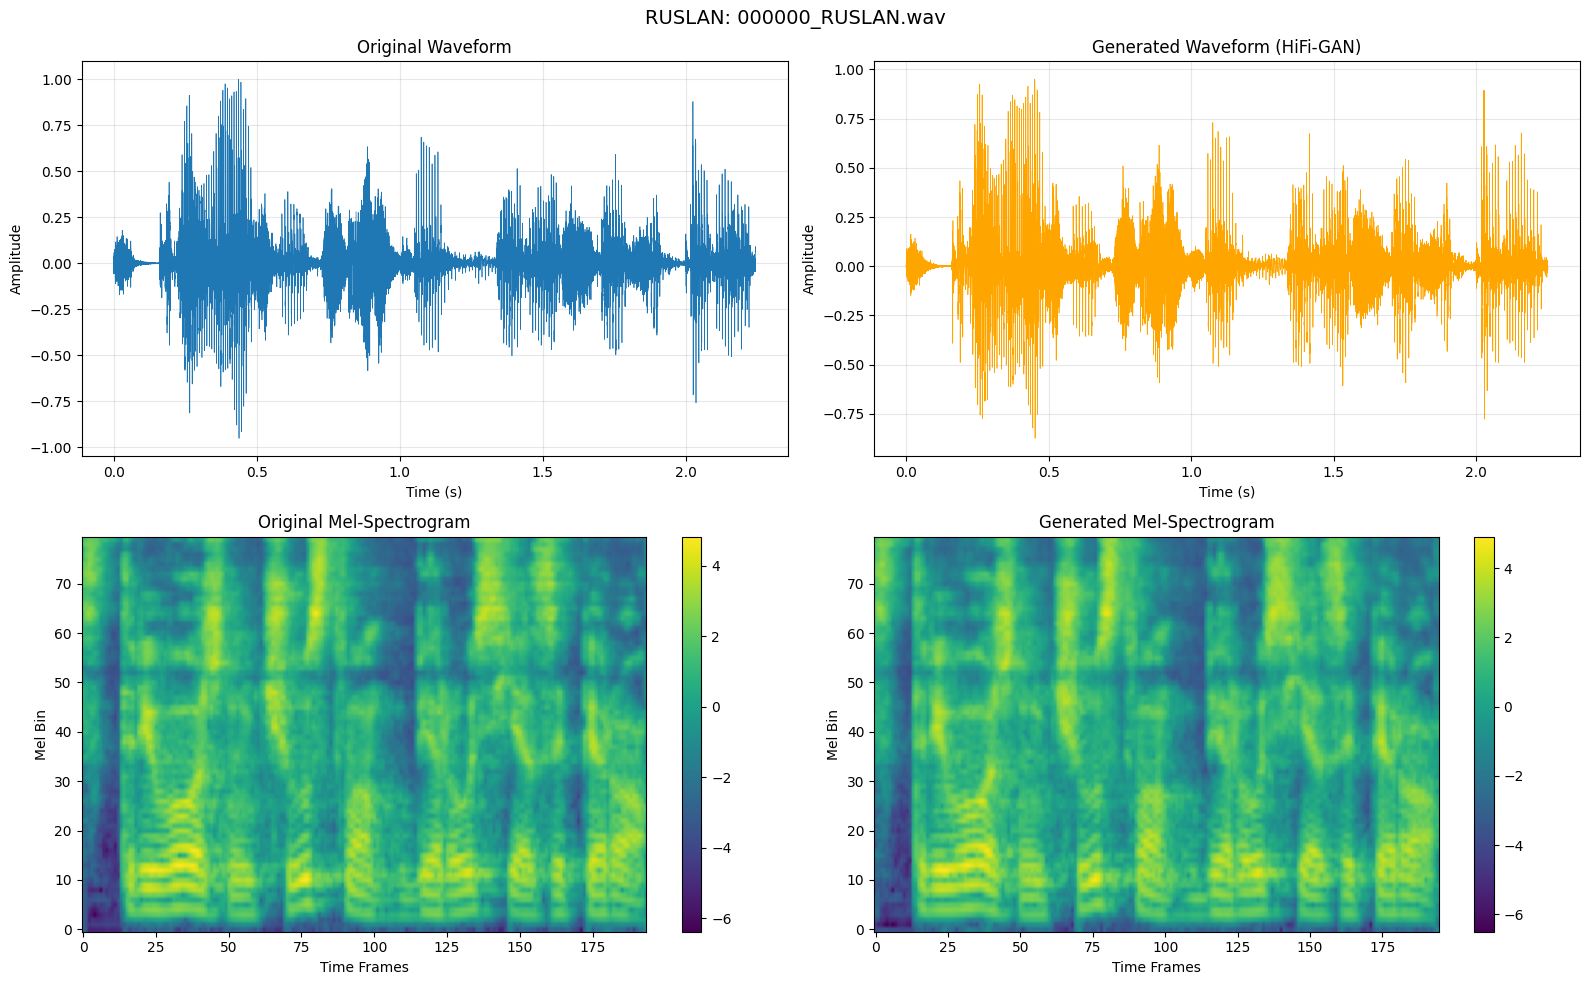

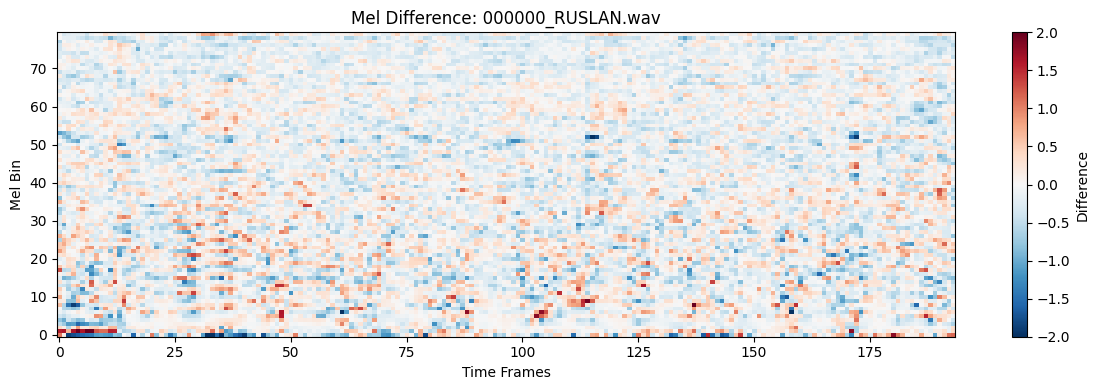

  Saved: ruslan_000000_RUSLAN_original.wav
  Saved: ruslan_000000_RUSLAN_generated.wav
  Mel L1 Distance: 0.2746

RUSLAN Example 2: 000001_RUSLAN.wav
  Saved plot: ruslan_000001_RUSLAN_comparison.png


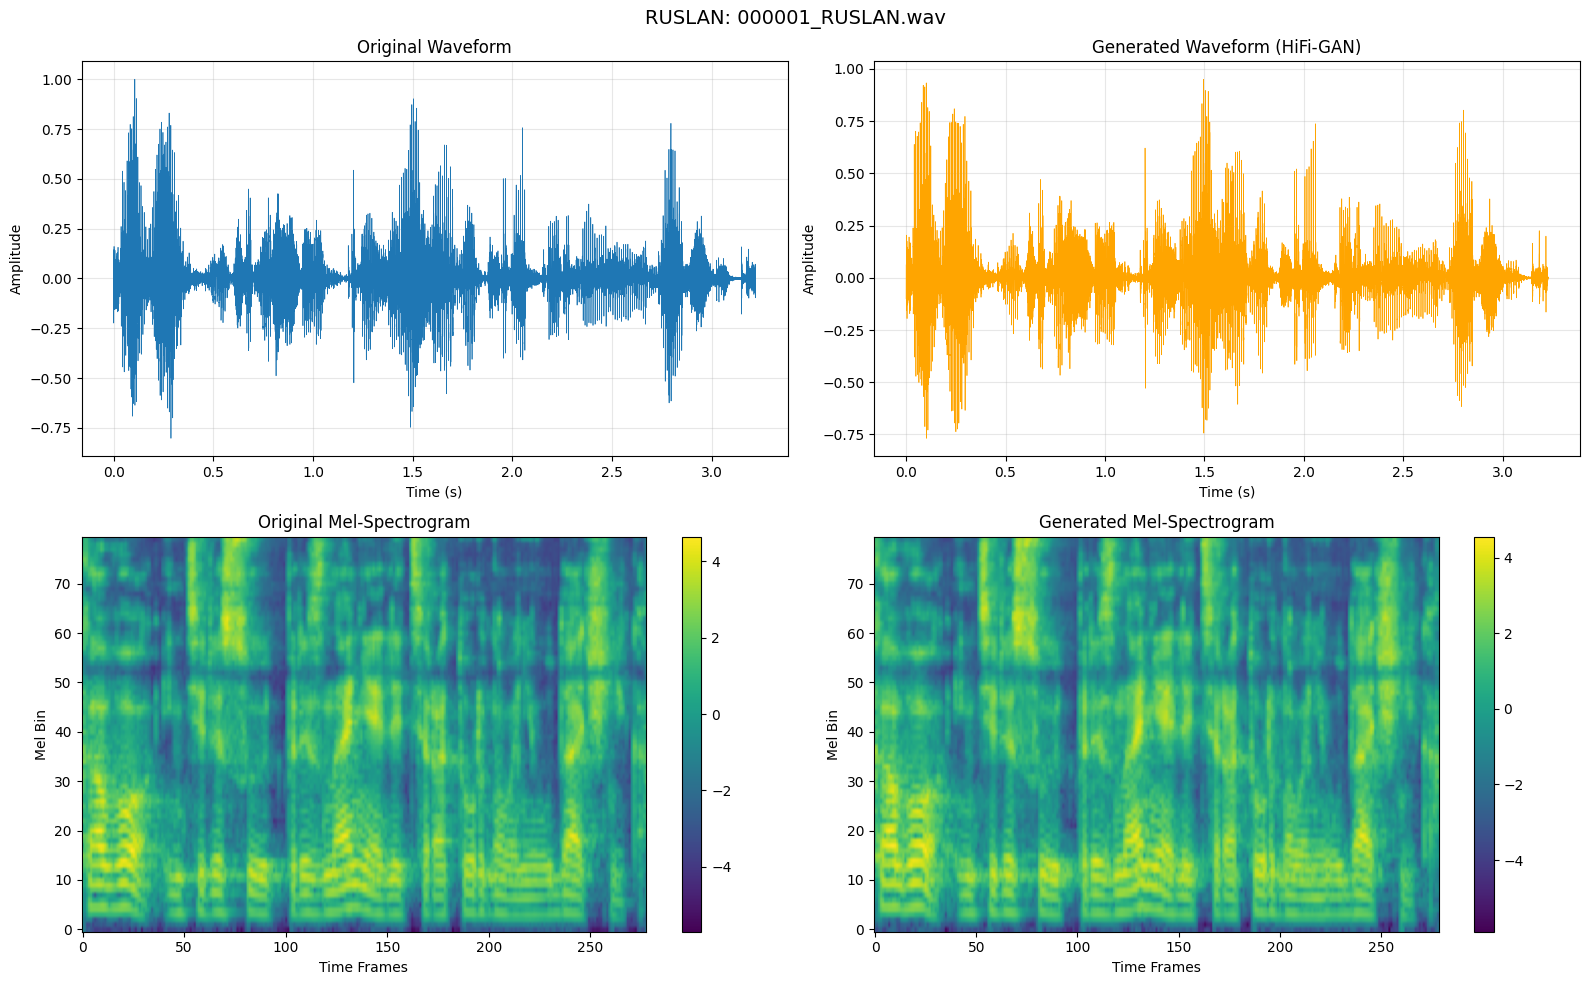

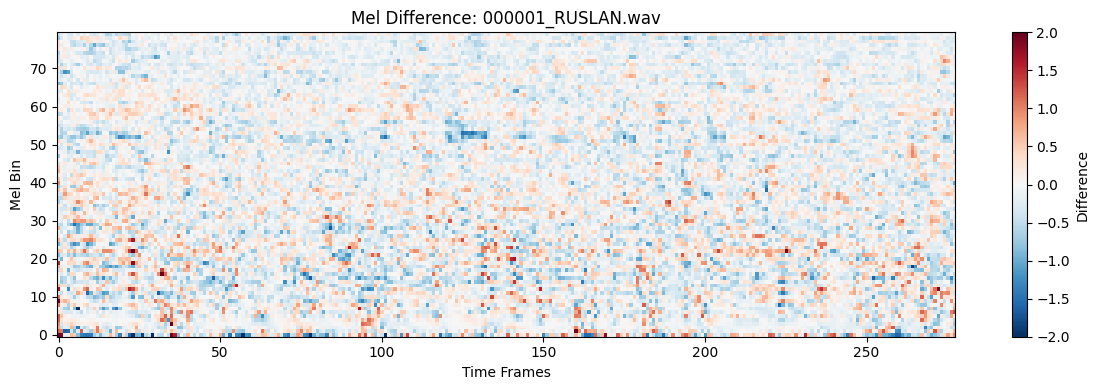

  Saved: ruslan_000001_RUSLAN_original.wav
  Saved: ruslan_000001_RUSLAN_generated.wav
  Mel L1 Distance: 0.2742

RUSLAN Example 3: 000002_RUSLAN.wav
  Saved plot: ruslan_000002_RUSLAN_comparison.png


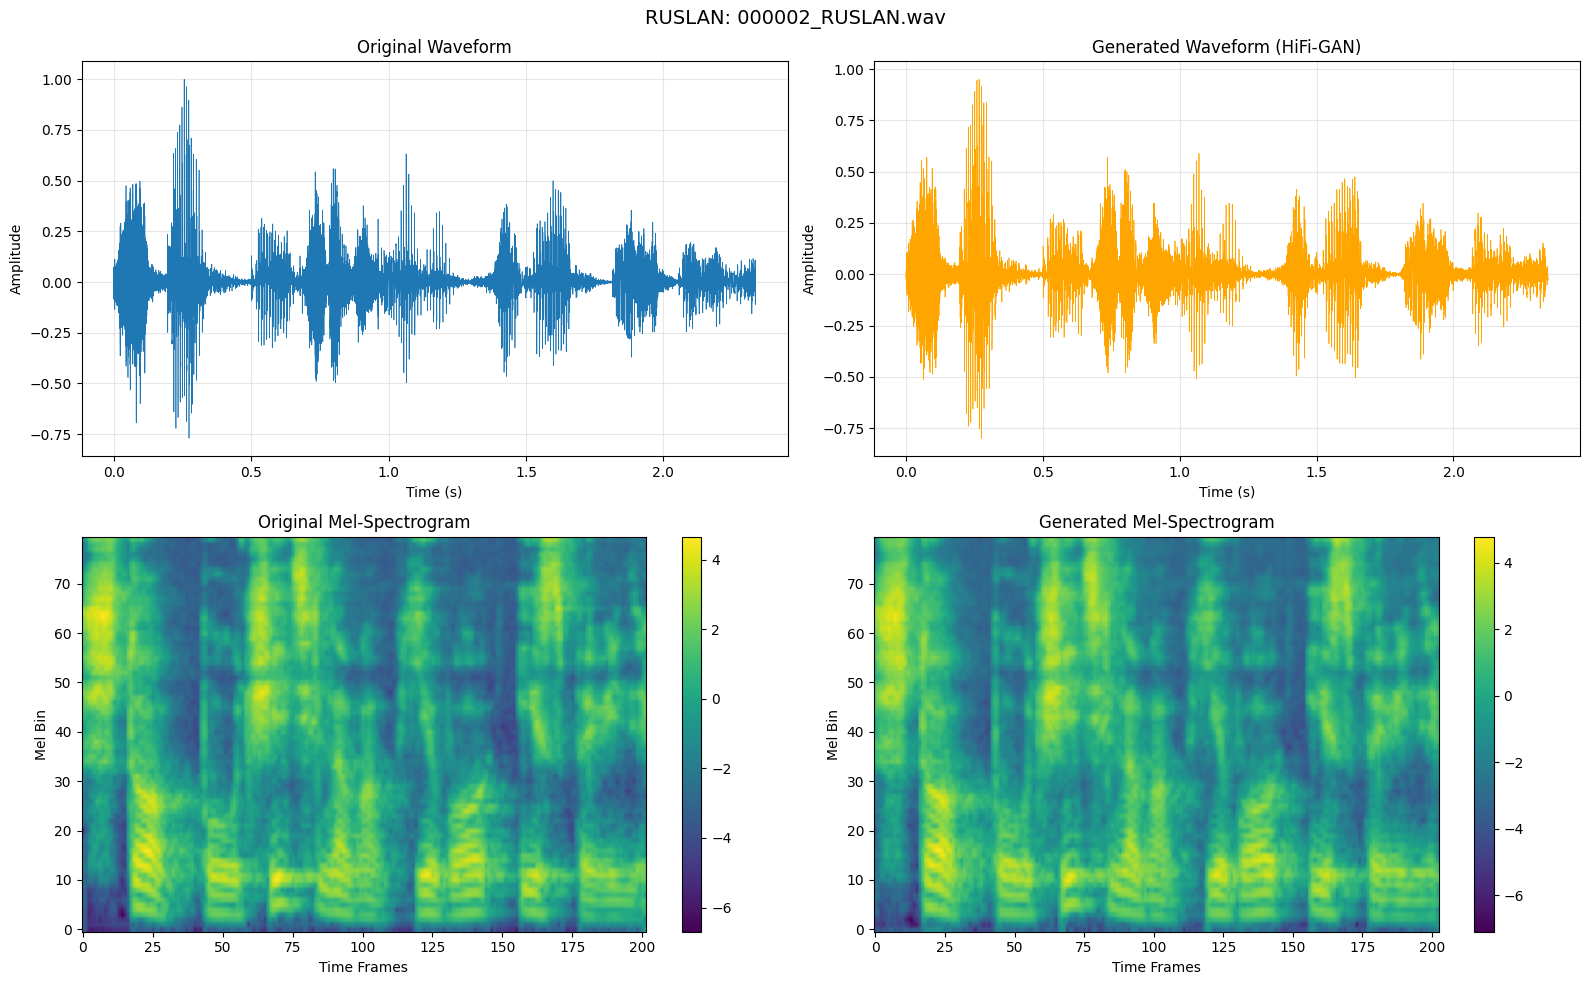

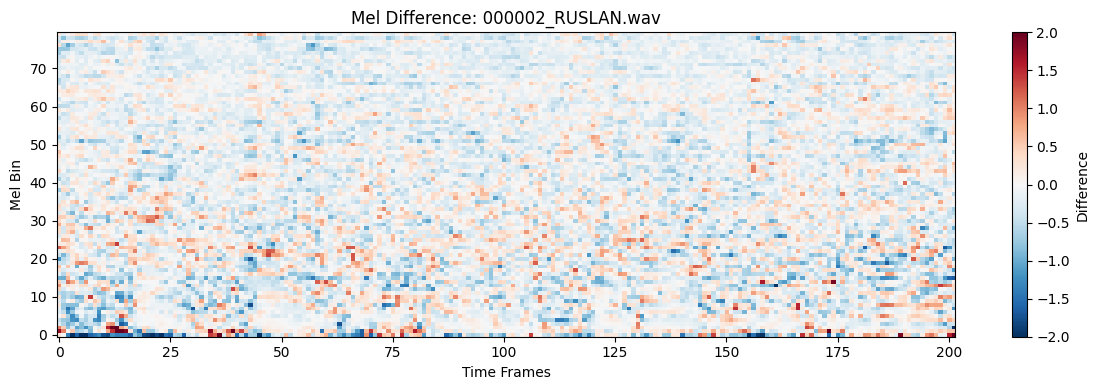

  Saved: ruslan_000002_RUSLAN_original.wav
  Saved: ruslan_000002_RUSLAN_generated.wav
  Mel L1 Distance: 0.2797


In [7]:
# Visualize and SAVE 3 examples from RUSLAN
if ruslan_files:
    for i, audio_path in enumerate(ruslan_files[:3]):
        print(f"\n{'='*60}")
        print(f"RUSLAN Example {i+1}: {audio_path.name}")
        print(f"{'='*60}")
        
        audio_orig, audio_gen, mel_input = resynthesize(
            audio_path, generator, mel_transform, device
        )
        mel_gen = mel_transform(audio_gen.to(device)).cpu()
        
        # Plot comparison
        name = audio_path.stem
        plot_comparison(
            audio_orig, audio_gen, mel_input, mel_gen, 
            title=f"RUSLAN: {audio_path.name}",
            save_path=OUTPUT_DIR / f"ruslan_{name}_comparison.png"
        )
        
        # Plot difference
        plot_difference(
            mel_input, mel_gen, 
            title=f"Mel Difference: {audio_path.name}",
            save_path=OUTPUT_DIR / f"ruslan_{name}_diff.png"
        )
        
        # SAVE audio to files (listen in any audio player!)
        save_audio(audio_orig, f"ruslan_{name}_original.wav")
        save_audio(audio_gen, f"ruslan_{name}_generated.wav")
        
        # Mel L1
        mel_l1 = compute_mel_l1(audio_orig, audio_gen, mel_transform, device)
        print(f"  Mel L1 Distance: {mel_l1:.4f}")
else:
    print("No RUSLAN files to visualize.")

### 1.1 Ответы на вопросы (RUSLAN)

1. **Какие различия вы видите?**
   
   > Различий практически нет, только небольшие на концах waveform

2. **Можно ли на слух понять, что аудио синтезировано?**
   
   > У сгенерированного аудио есть небольшие шумы. Если не слушать оригинал,то не возможно.

3. **Можно ли это определить по форме волны или спектрограмме?**
   
   > Можно по концам waveform в некоторых участках.

4. **Какие выводы вы можете сделать?**
   
   > Модель обучилась довольно хорошо, сгенерированное аудио от реального отличить практически не возможно.

---
## 2. Анализ на внешних данных

Берём аудиозаписи из тестовых предложений (раздел MOS).

In [10]:
# Путь к внешним тестовым данным (MOS sentences)
EXTERNAL_TEST_DIR = PROJECT_ROOT / 'data' / 'test' / 'audio'

# Альтернативные пути:
# EXTERNAL_TEST_DIR = PROJECT_ROOT / 'test_audio'

external_files = []
if EXTERNAL_TEST_DIR.exists():
    external_files = sorted(EXTERNAL_TEST_DIR.glob('*.wav'))[:20]
    print(f"Found {len(external_files)} external test files")
else:
    print(f"Directory not found: {EXTERNAL_TEST_DIR}")
    print("\nTo add external test data:")
    print(f"  mkdir -p {EXTERNAL_TEST_DIR}")
    print("  # Copy test .wav files there")

Found 10 external test files


In [11]:
# Analyze external samples
external_results = []

if external_files:
    for audio_path in tqdm(external_files, desc="Processing External"):
        audio_orig, audio_gen, mel_input = resynthesize(
            audio_path, generator, mel_transform, device
        )
        
        mel_l1 = compute_mel_l1(audio_orig, audio_gen, mel_transform, device)
        
        external_results.append({
            'file': audio_path.name,
            'mel_l1': mel_l1,
            'orig_len': len(audio_orig),
            'gen_len': len(audio_gen),
        })

    external_df = pd.DataFrame(external_results)
    print("\nExternal Results Summary:")
    print(external_df.describe())
else:
    print("No external files found.")
    external_df = pd.DataFrame()

Processing External: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


External Results Summary:
          mel_l1       orig_len        gen_len
count  10.000000      10.000000      10.000000
mean    0.422618   71367.700000   71475.200000
std     0.161927   40530.637764   40532.129666
min     0.249205   27277.000000   27392.000000
25%     0.268159   48441.750000   48512.000000
50%     0.410836   60638.000000   60800.000000
75%     0.583258   75887.750000   76096.000000
max     0.615582  147710.000000  147712.000000



External Example 1: 002021_RUSLAN.wav
  Saved plot: external_002021_RUSLAN_comparison.png


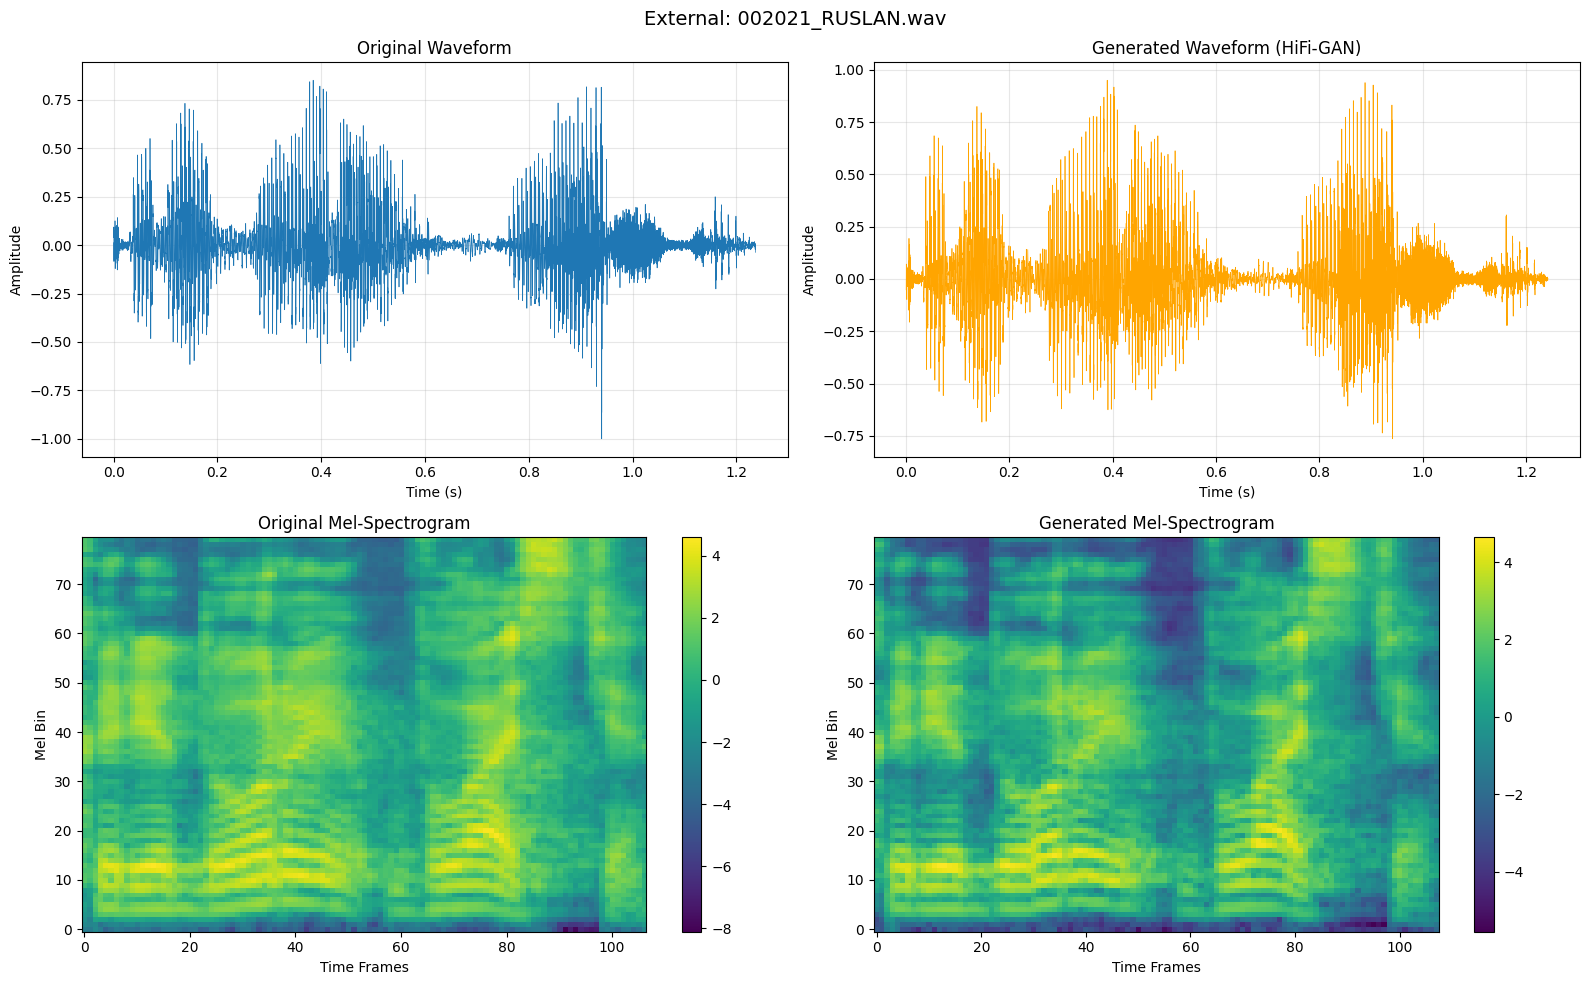

  Saved: external_002021_RUSLAN_original.wav
  Saved: external_002021_RUSLAN_generated.wav
  Mel L1 Distance: 0.3098

External Example 2: 004876_RUSLAN.wav
  Saved plot: external_004876_RUSLAN_comparison.png


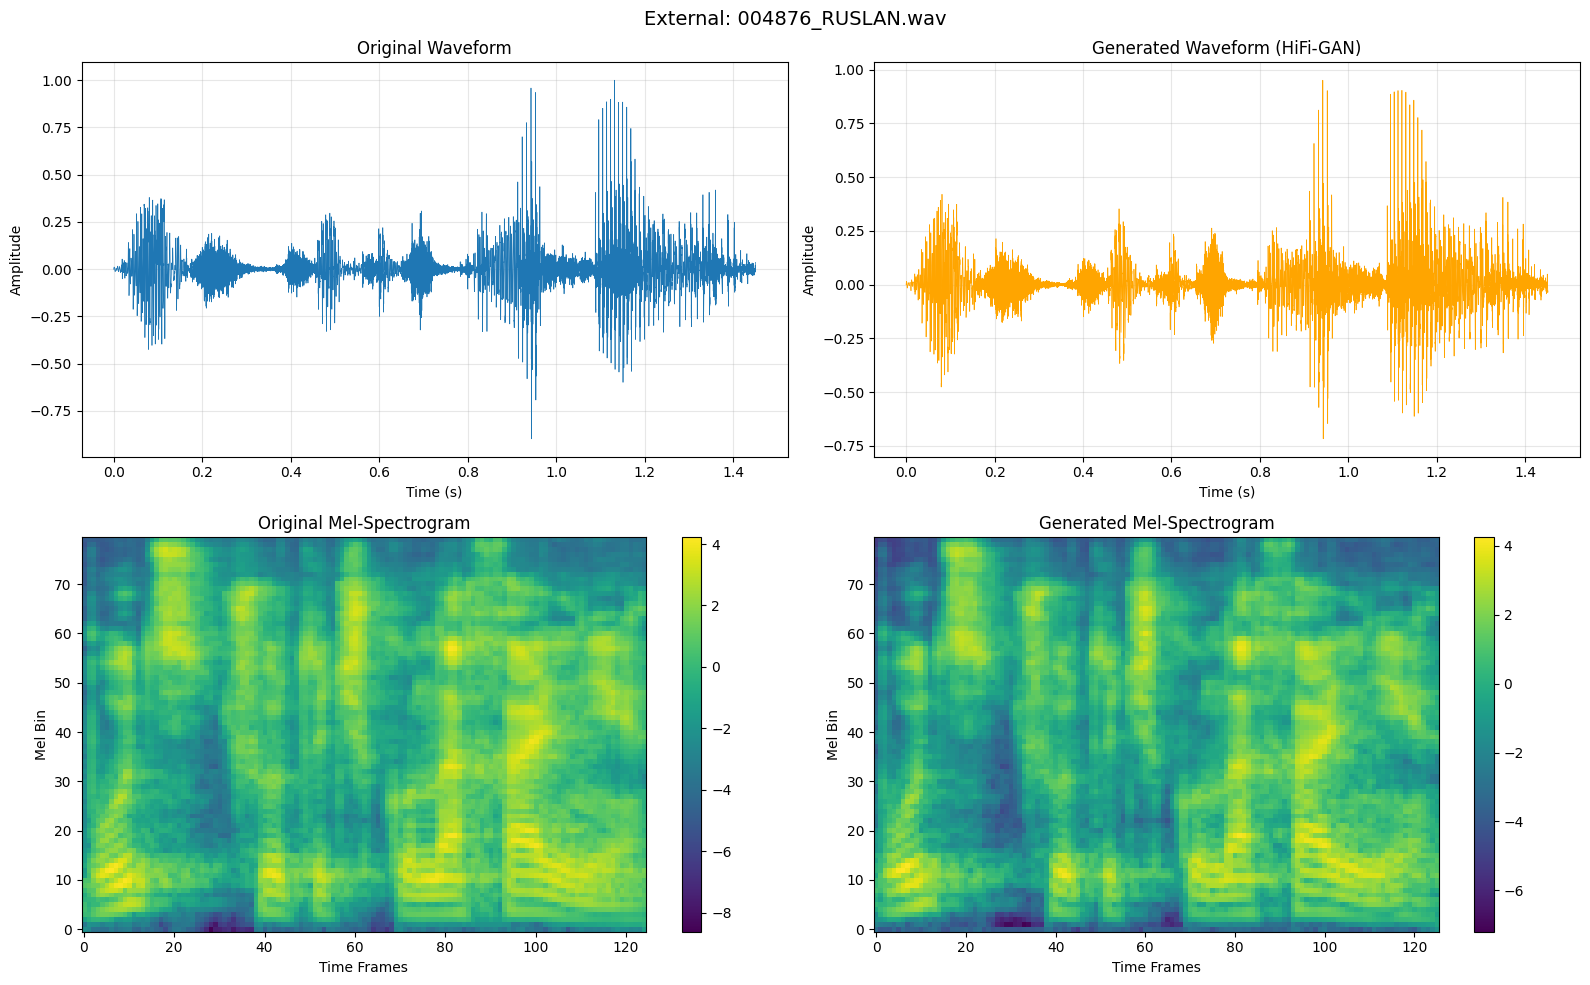

  Saved: external_004876_RUSLAN_original.wav
  Saved: external_004876_RUSLAN_generated.wav
  Mel L1 Distance: 0.2662

External Example 3: 007521_RUSLAN.wav
  Saved plot: external_007521_RUSLAN_comparison.png


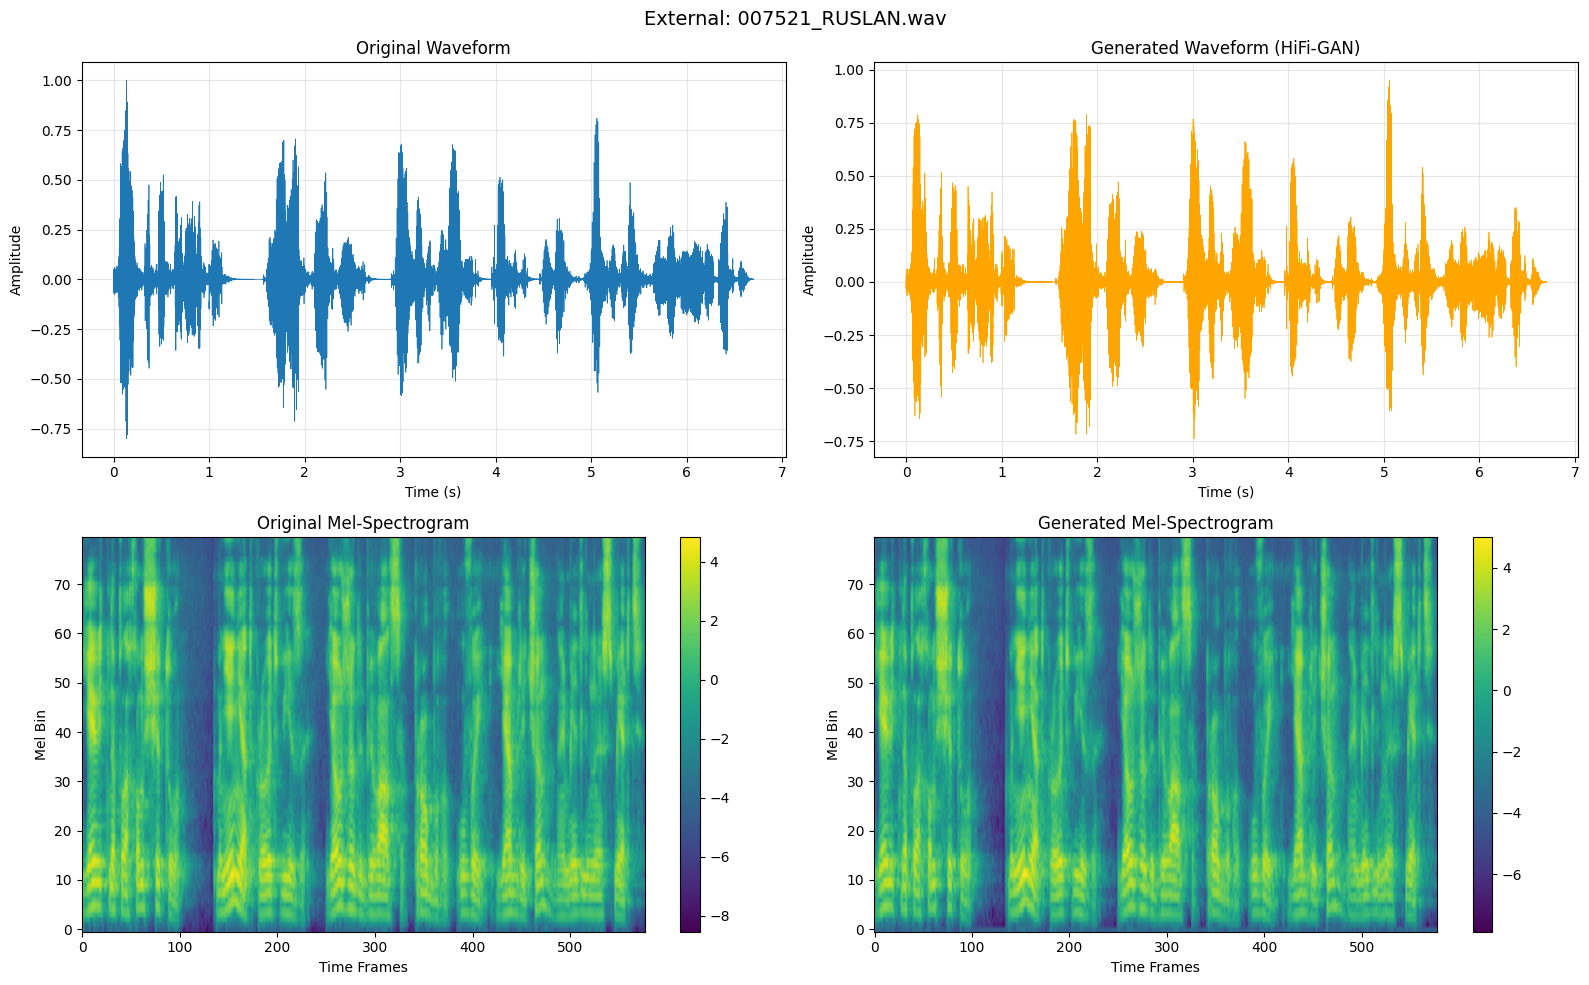

  Saved: external_007521_RUSLAN_original.wav
  Saved: external_007521_RUSLAN_generated.wav
  Mel L1 Distance: 0.2664


In [12]:
# Visualize and SAVE 3 examples from external data
if external_files:
    for i, audio_path in enumerate(external_files[:3]):
        print(f"\n{'='*60}")
        print(f"External Example {i+1}: {audio_path.name}")
        print(f"{'='*60}")
        
        audio_orig, audio_gen, mel_input = resynthesize(
            audio_path, generator, mel_transform, device
        )
        mel_gen = mel_transform(audio_gen.to(device)).cpu()
        
        name = audio_path.stem
        plot_comparison(
            audio_orig, audio_gen, mel_input, mel_gen,
            title=f"External: {audio_path.name}",
            save_path=OUTPUT_DIR / f"external_{name}_comparison.png"
        )
        
        # SAVE audio to files
        save_audio(audio_orig, f"external_{name}_original.wav")
        save_audio(audio_gen, f"external_{name}_generated.wav")
        
        mel_l1 = compute_mel_l1(audio_orig, audio_gen, mel_transform, device)
        print(f"  Mel L1 Distance: {mel_l1:.4f}")
else:
    print("No external files to visualize.")

Comparison: RUSLAN vs External
RUSLAN Mean Mel L1: 0.2680 ± 0.0100
External Mean Mel L1: 0.4226 ± 0.1619


/tmp/ipykernel_25389/2880668689.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([ruslan_df['mel_l1'], external_df['mel_l1']], labels=['RUSLAN', 'External'])


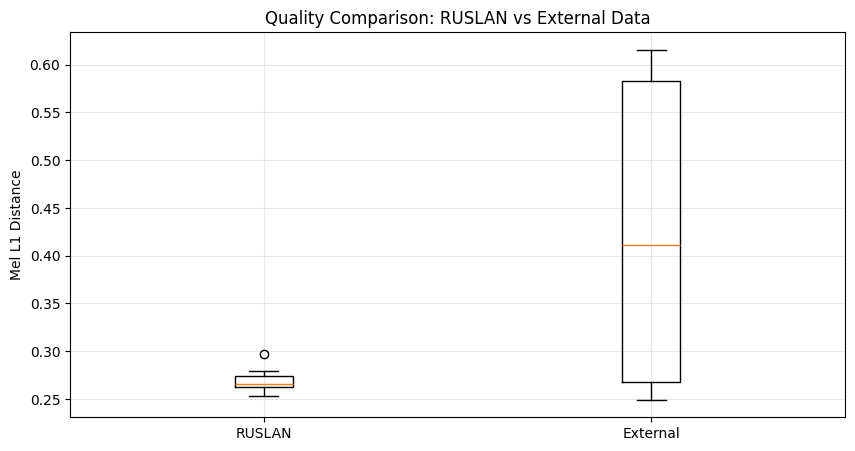

In [14]:
# Compare RUSLAN vs External
if len(ruslan_df) > 0 and len(external_df) > 0:
    print("Comparison: RUSLAN vs External")
    print("="*50)
    print(f"RUSLAN Mean Mel L1: {ruslan_df['mel_l1'].mean():.4f} ± {ruslan_df['mel_l1'].std():.4f}")
    print(f"External Mean Mel L1: {external_df['mel_l1'].mean():.4f} ± {external_df['mel_l1'].std():.4f}")

    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot([ruslan_df['mel_l1'], external_df['mel_l1']], labels=['RUSLAN', 'External'])
    ax.set_ylabel('Mel L1 Distance')
    ax.set_title('Quality Comparison: RUSLAN vs External Data')
    ax.grid(True, alpha=0.3)
    plt.savefig(OUTPUT_DIR / 'comparison_boxplot.png', dpi=150, bbox_inches='tight')
    plt.show()
elif len(ruslan_df) > 0:
    print(f"RUSLAN Mean Mel L1: {ruslan_df['mel_l1'].mean():.4f} ± {ruslan_df['mel_l1'].std():.4f}")
else:
    print("No data to compare.")

### 2.1 Ответы на вопросы (External)

**Заполните после анализа:**

1. **Справедливы ли выводы из анализа на обучающих данных?**
   
   > Частично. На RUSLAN модель показывает стабильно низкую ошибку (0.27), на external данных ошибка выше (0.42)

2. **Какие различия вы видите между обучающим и внешним датасетами?**
   
   > External имеет на 58% выше Mel L1 и в 16 раз выше дисперсию. Модель менее стабильна на unseen данных.

3. **Объясните причины различий, если они есть**
   
   > - Модель обучалась на RUSLAN (один спикер, определенные акустические условия), External данные (Silero TTS) имеют другой голос, интонацию, акустику, Это показывает типичное поведение domain gap.